# YouTube Video CTR Predictor: Capstone Project


## Business Case

<img src="images/tactiq.png" width="400" height="400" style="left" />



Social media companies worldwide have invested countless hours into hacking the YouTube algorithm, hoping to reverse-engineer the formula for success. An upcoming tech company, **TACTIQ**, is launching a product that employs machine learning to help YouTube creators optimize their videos to perform better. For the MVP of its new app, TACTIQ is looking to include a feature that tells YouTubers if their chosen video title will result in an optimal click-through-rate for the video. To do so, they will rely on data from published videos with confirmed CTRs to train a model that can predict. My task is to explore how this can be achieved and offer a model that provides reasonably accurate predictions. When I say "reasonably accurate," it's worth noting that a video click-through-rate depends on both its title and its thumbnail. It is not possible to predict CTR with 100% accuracy based on the title alone.

With that caveat out of the way, let's get started.

# EDA

Add table of contents

In [1]:
#Import libraries for data cleaning and analysis  

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk.corpus
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pyLDAvis.sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

import string
import os
from os import path
import regex as re
from PIL import Image

from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator

import spacy

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Helper Functions

def show_worldcloud(worldcloud):
    '''
    Input: worldcloud
    
    Output: displays a proprely formatted wordcloud
            within the notebook 
            
    '''
    
    plt.figure(figsize=(11,11), facecolor='w')
    plt.imshow(worldcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    
    
    
def contains_number(string):
    '''
    Input: a string object
    
    Ouputs: a bool value that confirms the
            presense of a number within the string
            
    '''
    
    if re.findall(r'\d+', string):
        return True
    else:
        return False 

### Prepare Data for EDA

My dataset contains a lot of information for each video, not all of which is relevant for the problem at hand. For the purpose of NLP, I only need the video title and the click-through-rate (CTR) represented either as a categorical variable or in its exact, numerical form. 

I'll also temporarily work with channel ids to determine what is the average CTR for each channel. Many factors influence a channel's CTR such as upload frequency, upload time, proportion of various traffic source, etc. I find it more useful to work with per-channel averages when it comes to CTR as opposed to an average across all channels. 

In [3]:
#Read organized dataset as a DataFrame
main = pd.read_csv('data/finalized/main_dataset.csv')

In [4]:
#Separate data for NLP into  a new DataFrame
vids = main[['video_id','video_title','ctr', 'channel_id']]

In [5]:
#Add a column that contains the length of each title
vids['title_length']  = vids['video_title'].str.len()

#Preview DataFrame
vids.head()

,video_id,video_title,ctr,channel_id,title_length
0,UYGj2P-cv-w,Hitting On Female Cops,10.07,UCg2Ba-ZPaID8OhE8JuBdYig,22
1,zUbsYwvD2z8,Naked Guy Picking Up Girls,5.75,UCg2Ba-ZPaID8OhE8JuBdYig,26
2,xNfSlKqZo_8,Flirting With Very Nice American Female Office...,11.23,UCg2Ba-ZPaID8OhE8JuBdYig,60
3,Ox5Ffa-1-hQ,NAKED GUY PICKING UP GIRLS IN USA,4.68,UCg2Ba-ZPaID8OhE8JuBdYig,33
4,kN3B3kDue64,Edgard Tries to Sell Me to This Brazilian Girl,3.86,UCg2Ba-ZPaID8OhE8JuBdYig,46


In [6]:
#Get mean CTR by channel
vids.groupby('channel_id', as_index=False)['ctr'].mean()[:3]

,channel_id,ctr
0,UCxY6aVCtHoVNkqBa5iYuyow,4.187906
1,UC-5AC4tBRWdUvDrlU0DMgwg,5.735902
2,UC0_CYeIk4l1Hxmdn9-QoR8A,5.999595


In [7]:
#Add Average CTR for the channel on which the video is uploaded to DataFrame
vids['channel_avg_ctr'] = vids.groupby('channel_id')['ctr'].transform('mean')

In [8]:
#Let's see some stats on the channel avg CTRs
vids.channel_avg_ctr.describe()

count    9410.000000
mean        4.553729
std         1.597280
min         0.959167
25%         3.263519
50%         4.490181
75%         5.735902
max         9.956429
Name: channel_avg_ctr, dtype: float64

The mean across all channels is about 4.5% CTR, which is lower than tha genre-average for other types of content on YouTube. In general, anything below 5% is considered a low CTR.

The **std of 1.6% makes sense**, and I'll use it later on as a comparison point to what a decent RMSE looks like when I try out Logistic Regression. If the model is able to predict within one std, that's a good baseline. Anything higher will not be very useful.

In [9]:
# Create classes based on CTR ranges:
# Low CTR < 4.55
# Avg CTR between 4.55 and 6.14 (one STD above mean)
# High CTR 6.15 >

def ctr_range(df):
    if df['ctr'] < 4.55:
        return 'Low CTR'
    elif 4.55 < df['ctr'] < 6.14:
        return 'Avg CTR'
    elif df['ctr'] > 6.14:
        return 'High CTR'
    else:
        return 'Undefined'

#Add the class to each video in the DataFrame
vids['ctr_range'] = vids.apply(ctr_range, axis=1)

#Preview DataFrame
vids.head(7)

,video_id,video_title,ctr,channel_id,title_length,channel_avg_ctr,ctr_range
0,UYGj2P-cv-w,Hitting On Female Cops,10.07,UCg2Ba-ZPaID8OhE8JuBdYig,22,3.871017,High CTR
1,zUbsYwvD2z8,Naked Guy Picking Up Girls,5.75,UCg2Ba-ZPaID8OhE8JuBdYig,26,3.871017,Avg CTR
2,xNfSlKqZo_8,Flirting With Very Nice American Female Office...,11.23,UCg2Ba-ZPaID8OhE8JuBdYig,60,3.871017,High CTR
3,Ox5Ffa-1-hQ,NAKED GUY PICKING UP GIRLS IN USA,4.68,UCg2Ba-ZPaID8OhE8JuBdYig,33,3.871017,Avg CTR
4,kN3B3kDue64,Edgard Tries to Sell Me to This Brazilian Girl,3.86,UCg2Ba-ZPaID8OhE8JuBdYig,46,3.871017,Low CTR
5,kmY8ag79uuk,Back at The Carnival | Brazil Trip 2020,2.51,UCg2Ba-ZPaID8OhE8JuBdYig,39,3.871017,Low CTR
6,Ceeuzy15bno,"Guy watches ""gay lovemaking"" with unplugged he...",5.53,UCg2Ba-ZPaID8OhE8JuBdYig,55,3.871017,Avg CTR


In [10]:
#Let's examine how many videos there are in each class
display(vids.ctr_range.value_counts())

Low CTR      5345
High CTR     2820
Avg CTR      1222
Undefined      23
Name: ctr_range, dtype: int64

There's a somewhat significant **class imbalance**, but I'll worry about it later. Potentially, I'll do a variation with only two classes, combining Avg + High CTR together.

In [11]:
#Drop the videos missing CTR that were classified as "undefined"
vids.drop(vids.loc[vids['ctr_range']=="Undefined"].index, inplace=True)

#Let's look at the normalized class balance
vids.ctr_range.value_counts(normalize=True)

Low CTR     0.569404
High CTR    0.300415
Avg CTR     0.130180
Name: ctr_range, dtype: float64

### EDA Using NLP

In [12]:
#Let's slice the DataFrame and keep only features that are relevant for NLP
df = vids[['video_id','video_title','ctr_range']]

#Preview
df.head(7)

,video_id,video_title,ctr_range
0,UYGj2P-cv-w,Hitting On Female Cops,High CTR
1,zUbsYwvD2z8,Naked Guy Picking Up Girls,Avg CTR
2,xNfSlKqZo_8,Flirting With Very Nice American Female Office...,High CTR
3,Ox5Ffa-1-hQ,NAKED GUY PICKING UP GIRLS IN USA,Avg CTR
4,kN3B3kDue64,Edgard Tries to Sell Me to This Brazilian Girl,Low CTR
5,kmY8ag79uuk,Back at The Carnival | Brazil Trip 2020,Low CTR
6,Ceeuzy15bno,"Guy watches ""gay lovemaking"" with unplugged he...",Avg CTR


##### Text Cleaning

As we can see from the preview, some titles contain punctuation and special characters. Others also contain numbers such as the year, or a number indicating a listicale. Most titles also include a lot of capitalized words. For the moment, I'll take the traditional text cleaning steps and remove all of that.

In [13]:
#Removing punctuation 
df['clean_title'] = df['video_title'].apply(lambda x: re.sub('\W+',' ', x))

In [14]:
#Converting everything into lowercase

df['clean_title'] = df['clean_title'].apply(lambda x: x.lower())

df['clean_title'].head(7)

0                               hitting on female cops
1                           naked guy picking up girls
2    flirting with very nice american female office...
3                    naked guy picking up girls in usa
4       edgard tries to sell me to this brazilian girl
5                back at the carnival brazil trip 2020
6    guy watches gay lovemaking with unplugged head...
Name: clean_title, dtype: object

In [15]:
#Check if the title contains a number
df['contains_number'] = df['clean_title'].apply(contains_number)

#Let's see the berakdown of titles with/out numbers:
df.contains_number.value_counts()

False    6737
True     2650
Name: contains_number, dtype: int64

Most titles do not contain numbers. I'm curious to see what the CTR is for titles that do! 

In [16]:
#Check titles with numbers per CTR range
df.groupby('ctr_range')['contains_number'].sum()

ctr_range
Avg CTR      303.0
High CTR     753.0
Low CTR     1594.0
Name: contains_number, dtype: float64

The presence of numbers seems to lead to a lower CTR, but if I treat the other two classes as one, it doesn't seem to make much of a difference. For now, I'll remove all numbers.

In [17]:
# Remove numbers from titles
df['clean_title'] = df['clean_title'].apply(lambda x: re.sub('\w*\d\w*','', x))

#### Tokenization 

Next, let's tokenize each title and turn each word into each own token.

In [18]:
#Initialize a tokenizer
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

In [19]:
#Tokenize the pre-cleaned video title and save the tokend in a new column
df['tokenized_title'] = df.apply(lambda row: tokenizer.tokenize(row['clean_title']), axis=1)

#Let's preview
df[['clean_title', 'tokenized_title']].head() 

,clean_title,tokenized_title
0,hitting on female cops,"[hitting, on, female, cops]"
1,naked guy picking up girls,"[naked, guy, picking, up, girls]"
2,flirting with very nice american female office...,"[flirting, with, very, nice, american, female,..."
3,naked guy picking up girls in usa,"[naked, guy, picking, up, girls, in, usa]"
4,edgard tries to sell me to this brazilian girl,"[edgard, tries, to, sell, me, to, this, brazil..."


Everything looks good. Now that I have tokenized the titles, let's take a look at a wordcloud across all videos.

(-0.5, 499.5, 499.5, -0.5)

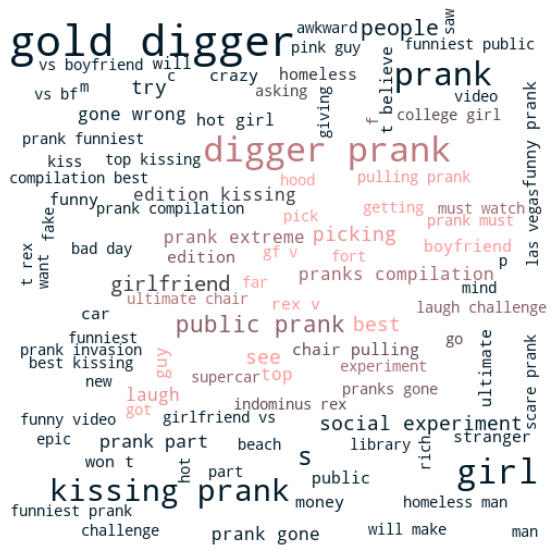

In [20]:
#Let's create a WordCloud object generated with all tokens as strings

tactiq_color = np.array(Image.open('images/tactiq_icon.png'))

#prepare titles
text = df['tokenized_title'].to_string()

#initialize WorldCloud() object
wc = WordCloud(background_color="white", max_words=100, mask=tactiq_color,
               max_font_size=40, random_state=42)

# generate word cloud
wc.generate(text)

# create coloring from image
image_colors = ImageColorGenerator(tactiq_color)

# show plot
plt.figure(figsize=(20,10))
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis('off')


#Generic WorldCloud 
# text = WordCloud().generate(df['tokenized_title'].to_string())
# show_worldcloud(text)

It appears that a lot of the pranks revolve around "gold digger", take place in public and as a social experiment. It also seems like most pranks involve a girl or a girlfriend. Depending on the results of more EDA, I might add some of these frequent words to the list of stopwords.

##### Remove Stopwords

In [21]:
#Let's slice the DataFrame again and keep only the clean title, the tokenized title, and the CTR
df = df[['clean_title','tokenized_title','ctr_range']]

In [22]:
#Let's store the standard stopwords list from NLTK into a variable 
stopwords = stopwords.words('english')
stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [23]:
# How many stopwords in titles?
df['stopwords'] = df['clean_title'].apply(lambda x: len([x for x in x.split() if x in stopwords]))
df[['clean_title','stopwords']].head(10)

,clean_title,stopwords
0,hitting on female cops,1
1,naked guy picking up girls,1
2,flirting with very nice american female office...,3
3,naked guy picking up girls in usa,2
4,edgard tries to sell me to this brazilian girl,4
5,back at the carnival brazil trip,2
6,guy watches gay lovemaking with unplugged head...,1
7,awkwardly asking girls out for valentine s day,3
8,how did you dare to pick up girls naked,5
9,most embarrassing prank wear headphones,1


In [24]:
#Let's remove all stopwords  
df['clean_title'] = df['clean_title'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))

#Preview the result of the updated clean title
df['clean_title'].head(7)

0                                hitting female cops
1                            naked guy picking girls
2    flirting nice american female officer norwegian
3                        naked guy picking girls usa
4                   edgard tries sell brazilian girl
5                          back carnival brazil trip
6    guy watches gay lovemaking unplugged headphones
Name: clean_title, dtype: object

##### Exploring Word Frequencies

Now that all stopwords are removed, let's examine what words appear most frequently across the entire dataset as well as within each of the classes.

In [25]:
# Most frequent words across the board 
frequent_words = pd.Series(' '.join(df['clean_title']).split()).value_counts()

#Let's display the top 30 most frequent words 
frequent_words[:30]

prank          3543
gold           1393
pranks         1288
digger         1235
girls           881
vs              696
funny           674
kissing         674
public          581
compilation     578
gone            547
social          538
experiment      532
best            532
edition         435
top             425
people          421
laugh           389
girlfriend      386
challenge       385
part            342
wrong           332
watch           320
girl            316
funniest        298
homeless        294
try             288
money           267
must            260
ultimate        247
dtype: int64

In [26]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

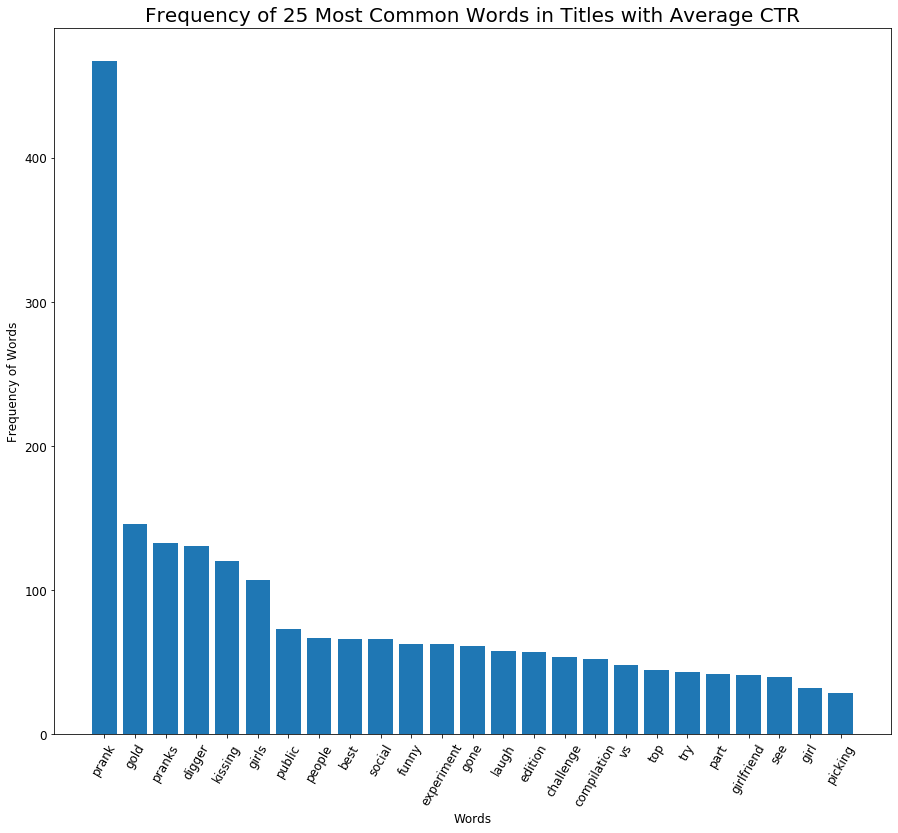

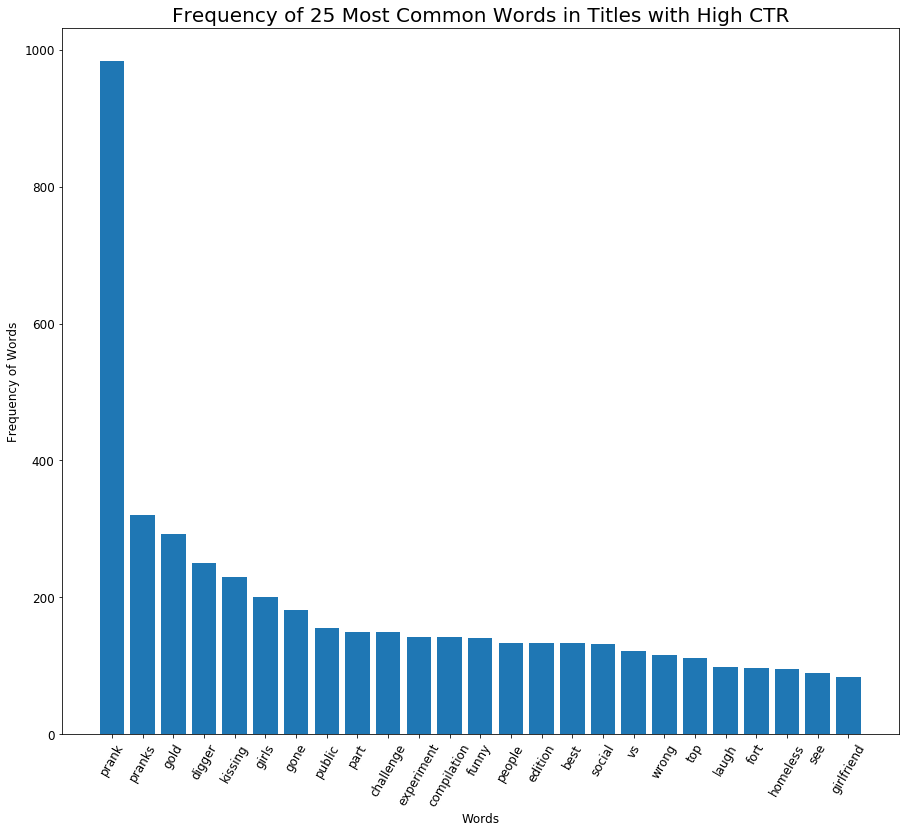

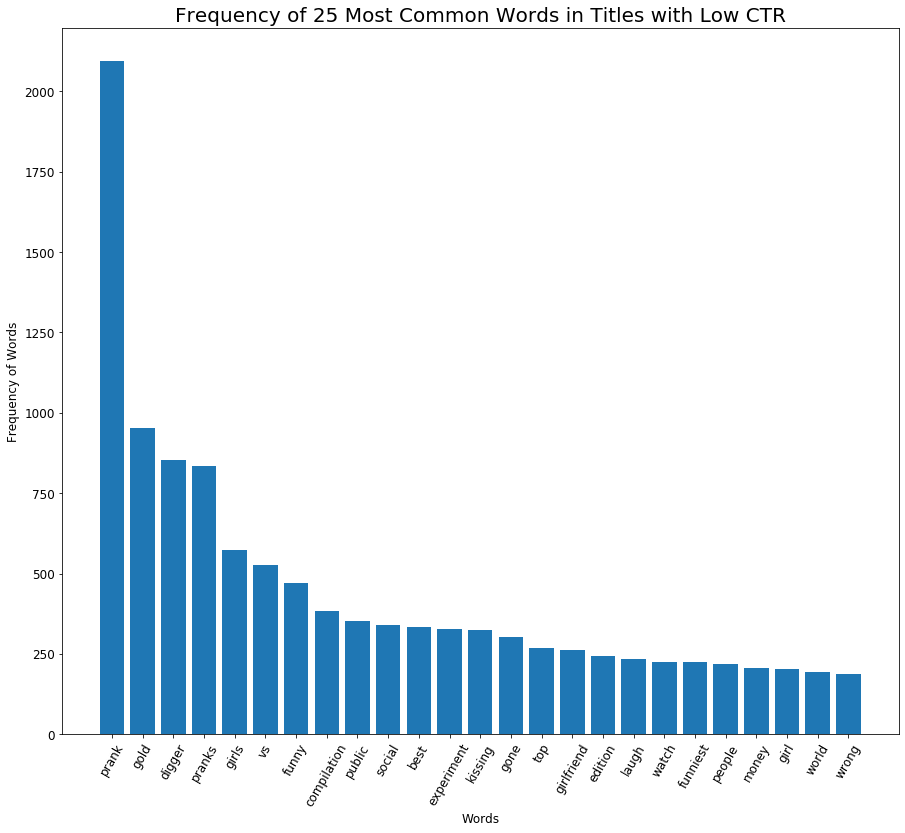

In [27]:
#Let's visualize the top 25 most common words in each CTR class
group_by = df.groupby('ctr_range')['clean_title'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))

for i in (0,1,2):
    group_by_ctr = group_by.iloc[i]

    words0 = list(zip(*group_by_ctr))[0]
    freq0 = list(zip(*group_by_ctr))[1]

    plt.figure(figsize=(15,13))
    plt.bar(words0, freq0)
    plt.xlabel('Words', fontsize=12)
    plt.ylabel('Frequency of Words', fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(rotation=60, fontsize=12)
    if i == 0:
        plt.title('Frequency of 25 Most Common Words in Titles with Average CTR', fontsize=20)
        plt.show()
    elif i== 1:
        plt.title('Frequency of 25 Most Common Words in Titles with High CTR', fontsize=20)
        plt.show()
    else:
        plt.title('Frequency of 25 Most Common Words in Titles with Low CTR', fontsize=20)
        plt.show()

In [28]:
#verify CTRs placement for the loop above
display(group_by)

ctr_range
Avg CTR     [(prank, 467), (gold, 146), (pranks, 133), (di...
High CTR    [(prank, 983), (pranks, 321), (gold, 293), (di...
Low CTR     [(prank, 2093), (gold, 954), (digger, 853), (p...
Name: clean_title, dtype: object

##### Implement Lemmatization 

In [29]:
def lemmatize_title(title):
    '''
    Input: a video title as a list of tokens
    
    Output: a list of lemmatized tokens
    
    '''
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in title]

In [30]:
#Update the tokenized title column by tokenizing the title without stopwords
df['tokenized_title'] = df.apply(lambda row: tokenizer.tokenize(row['clean_title']), axis=1)

#Add a new colimn where each tokens are lemmas
df['lemm_title'] = df['tokenized_title'].apply(lemmatize_title)

#Preview
df.head(5)

,clean_title,tokenized_title,ctr_range,stopwords,lemm_title
0,hitting female cops,"[hitting, female, cops]",High CTR,1,"[hitting, female, cop]"
1,naked guy picking girls,"[naked, guy, picking, girls]",Avg CTR,1,"[naked, guy, picking, girl]"
2,flirting nice american female officer norwegian,"[flirting, nice, american, female, officer, no...",High CTR,3,"[flirting, nice, american, female, officer, no..."
3,naked guy picking girls usa,"[naked, guy, picking, girls, usa]",Avg CTR,2,"[naked, guy, picking, girl, usa]"
4,edgard tries sell brazilian girl,"[edgard, tries, sell, brazilian, girl]",Low CTR,4,"[edgard, try, sell, brazilian, girl]"


In [31]:
#Remove videos where the lemma list is empty - it happend to a few videos that were titled in Russian

print(df.shape)

df = df[~df.lemm_title.str.len().eq(0)]
print(df.shape)

(9387, 5)
(9381, 5)


##### Topic Modeling using Bag of Words

Let's explore the topcis of all titles, as well as what topics seem more prevelant for certain classes.

In [32]:
#First, let's convert the lists of lemmas into strigs
df['lemma_str'] = [' '.join(map(str,l)) for l in df['lemm_title']]

#Initialize a Count Vectorizer 
cv = CountVectorizer(max_df=0.9)
tf = cv.fit_transform(df['lemma_str'].values.astype('U')) #Create a sparse matrix of the values
tf_feature_names = cv.get_feature_names() #extract all lemas into a list

#Create a matrix where each lemma is the column and the values replresent its presence in the document/title
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix.head()

,ab,abandon,abandoned,abducted,abducting,absolutely,abuse,abused,abusing,abusive,...,yuck,zao,zebulon,zedd,zombie,zone,zoned,zoo,zooming,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
#Let's initialize a Latent Dirichlet Allocation model that will help us seaprate titles into clusters/topics
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online',
                                      max_iter=250, random_state=0).fit(tf)

def display_topics(model, feature_names, num_top_words):
    '''
    Input: an LDA model, a list of lemma/swords, and # of desired words per cluster
    
    Output: prints the top # of words for each topic
    
    '''
    
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-num_top_words - 1:-1]]))
              
display_topics(lda_model, tf_feature_names, 10)

Topic 0:
prank funny laugh video funniest try see best fight day
Topic 1:
edition lamborghini stranger uber awkward stealing getting food random night
Topic 2:
experiment social watch homeless must girl money man rich college
Topic 3:
prank gold digger kissing gone wrong part top girl compilation
Topic 4:
girl world hot asking vega wife gym boy sex buying
Topic 5:
prank public compilation best top car get funny believe people
Topic 6:
girl guy picking crazy jurassic evolution breakout want like pick
Topic 7:
challenge extreme gf bf kiss la life ft real music
Topic 8:
girlfriend boyfriend cheating phone caught right friend make almost hour
Topic 9:
people fort hand secret drive youtube hidden battle comment thru


In [34]:
#Creates an interactive visualization for each cluster/topic
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tf, cv, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3      32.420952   8.115230       1        1  22.519932
0       0.648955  71.707100       2        1  13.582208
5      71.019684   9.971006       3        1  11.681928
2       3.785981  33.185135       4        1  10.464092
6     -42.666500  -9.222070       5        1   9.362759
7      -3.621689 -43.526516       6        1   7.015241
1      -3.632402  -4.171708       7        1   6.678797
4     -36.584400  35.804413       8        1   6.297376
9      44.391380  50.615383       9        1   6.211024
8      40.235809 -31.591665      10        1   6.186643, topic_info=            Term         Freq        Total Category  logprob  loglift
2756       prank  4309.000000  4309.000000  Default  30.0000  30.0000
1527        gold  1233.000000  1233.000000  Default  29.0000  29.0000
1001      digger  1217.000000  1217.000000  Default  28.0000  28.0000
1508        girl  1128.000000  1128.000000  Default  27.0000  27.0000
1235  experiment   568.000000   568.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
3520      street    16.352530    17.190145  Topic10  -5.2064   2.7328
229    awkwardly    16.206507    17.044137  Topic10  -5.2153   2.7324
330       better    15.283989    16.121626  Topic10  -5.2739   2.7294
2986     revenge    23.924120    32.427053  Topic10  -4.8259   2.4787
2188        make    40.040403   155.046138  Topic10  -4.3109   1.4289

[367 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
22        5  0.961539  acrocanthosaurus
23        4  0.982133               act
50        8  0.935226            advice
87        5  0.968880        allosaurus
89       10  0.967217            almost
...     ...       ...               ...
4115      8  0.995977             world
4121      4  0.973968             would
4129      1  0.998519             wrong
4144      3  0.979303              year
4164      9  0.973268           youtube

[346 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 6, 3, 7, 8, 2, 5, 10, 9])

##### Topic Modeling Using TF-IDF

The visualization and topics above are useful, but they take a long time to compute. I'm going to use a different vectorizing techniques and a different model to extrac topics: TF-IDF with an NMF model.

In [35]:
#Similarly to what I did above, I'm creating a doc-term matrix for all lemmas using the TF-IDF vectorizer.
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(df['lemma_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf.head()

,ab,abandon,abandoned,abducted,abducting,absolutely,abuse,abused,abusing,abusive,...,yuck,zao,zebulon,zedd,zombie,zone,zoned,zoo,zooming,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
#Initialize a NMF model that detects 10 components(topics) 
nmf = NMF(n_components=10, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)

#Display the topics
display_topics(nmf, tfidf_feature_names, 10)

Topic 0:
gold digger prank part exposed savage top money edition lamborghini
Topic 1:
prank public funniest compilation best chair pulling ultimate top people
Topic 2:
laugh funny try challenge video make best day bad fails
Topic 3:
experiment social money homeless rich man poor people honesty dropping
Topic 4:
kissing prank edition extreme invasion top best prankinvasion game compilation
Topic 5:
world jurassic evolution rex fight breakout dinosaur spinosaurus indominus indoraptor
Topic 6:
girl picking hot guy asking money college pick get want
Topic 7:
gone wrong prank girlfriend boyfriend cheating gf bf hood far
Topic 8:
see saw lamborghini homeless car mind changed ferrari knew happens
Topic 9:
watch must part believe video material wife new shampoo bad


Based on the keywords above, I can roughly group these videos into the topics below. Some topics repeat because the keywords seem related and it will help me visualize them easier down the line.


#### Topics:

* Topic 1: Materialistic 
* Topic 2: Comedy in Public
* Topic 3: Challenge 
* Topic 4: Social Experiment
* Topic 5: Flirt-based
* Topic 6: Extreme Pranks
* Topic 7: Flirt-based
* Topic 8: Couple pranks 
* Topic 9: Materialistic 
* Topic 10: Mixed 

In [37]:
#Grab the topics and assign each video to a topic index (as a new column)
topic_values = nmf.transform(tfidf)

df['topics'] = topic_values.argmax(axis=1)

#Preview
df[['lemma_str','topics']].head()

,lemma_str,topics
0,hitting female cop,7
1,naked guy picking girl,6
2,flirting nice american female officer norwegian,6
3,naked guy picking girl usa,6
4,edgard try sell brazilian girl,6


In [38]:
#let's create a dictionary with all topcis and map those to the topics column:
topics = {0: 'Materialistic', 1: 'Comedy in Public', 2: 'Challenge', 3: 'Social Experiment', 
             4: 'Flirt-based', 5: 'Extreme Pranks', 6: 'Flirt-based', 7: 'Couple pranks', 
             8: 'Materialistic', 9: 'Mixed'}

df['topics'] = df['topics'].map(topics)

#Preview
df[['lemma_str','topics']].head()

,lemma_str,topics
0,hitting female cop,Couple pranks
1,naked guy picking girl,Flirt-based
2,flirting nice american female officer norwegian,Flirt-based
3,naked guy picking girl usa,Flirt-based
4,edgard try sell brazilian girl,Flirt-based


(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.,
        2250.]), <a list of 10 Text xticklabel objects>)

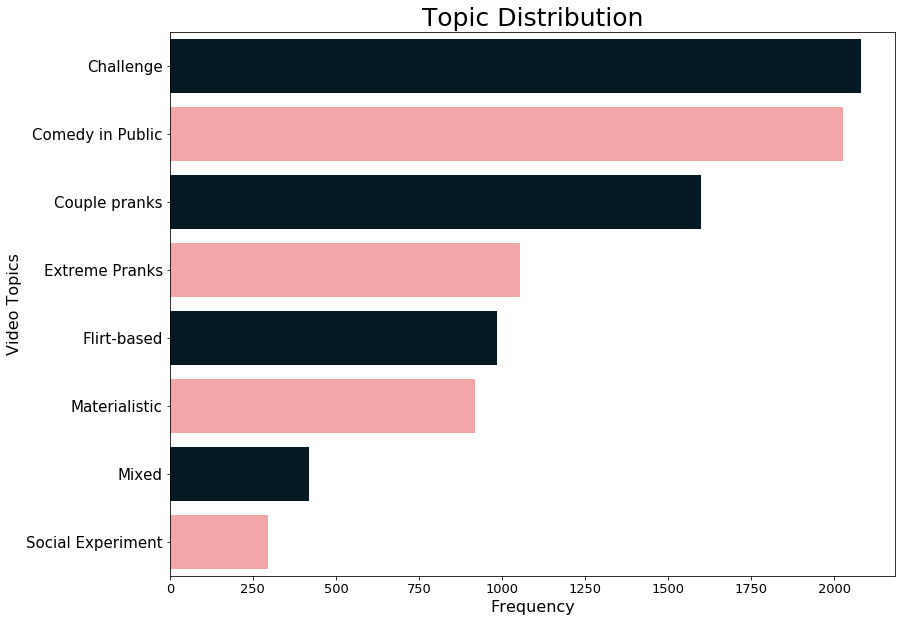

In [39]:
#Let's look at the topic distribution for the entire dataset
enmax_palette = ["#ff9999", "#001a29"]
color_codes_wanted = ['background', 'tactiq']
c = lambda x: enmax_palette[color_codes_wanted.index(x)]

sns.set_palette(sns.color_palette(enmax_palette))

graph_x = df['topics'].value_counts()
graph_y = graph_x.sort_index()
plt.figure(figsize=(13,10))
sns.barplot(graph_x, graph_y.index, palette=[c('tactiq'), c('background'),
                                             c('tactiq'), c('background'),
                                             c('tactiq'), c('background'),
                                             c('tactiq'), c('background'),])
plt.title("Topic Distribution", fontsize=25)
plt.ylabel('Video Topics', fontsize=16)
plt.yticks(fontsize=15)
plt.xlabel('Frequency', fontsize=16)
plt.xticks(fontsize=13)

In [40]:
#Let's split the DataFrame into three DFs based on CTR
low_ctr = df.loc[(df['ctr_range']=='Low CTR')]
avg_ctr = df.loc[(df['ctr_range']=='Avg CTR')]
high_ctr = df.loc[(df['ctr_range']=='High CTR')]

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 <a list of 7 Text xticklabel objects>)

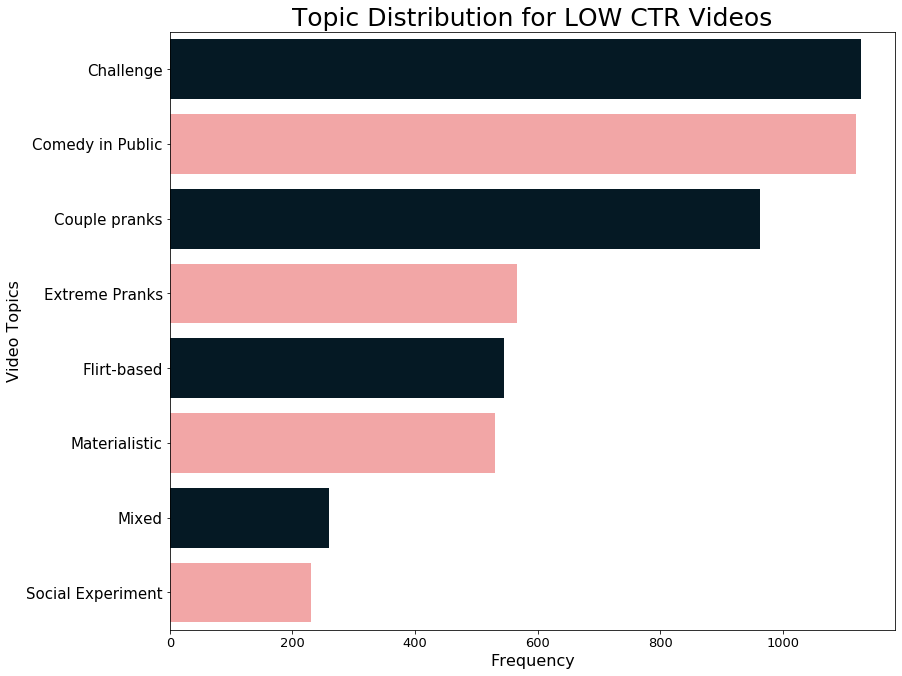

In [43]:
low_x = low_ctr['topics'].value_counts()
low_y = low_x.sort_index()
plt.figure(figsize=(13,11))
sns.barplot(low_x, low_y.index, palette=[c('tactiq'), c('background'),
                                             c('tactiq'), c('background'),
                                             c('tactiq'), c('background'),
                                             c('tactiq'), c('background')])
plt.title("Topic Distribution for LOW CTR Videos", fontsize=25)
plt.ylabel('Video Topics', fontsize=16)
plt.yticks(fontsize=15)
plt.xlabel('Frequency', fontsize=16)
plt.xticks(fontsize=13)

(array([  0.,  50., 100., 150., 200., 250., 300., 350.]),
 <a list of 8 Text xticklabel objects>)

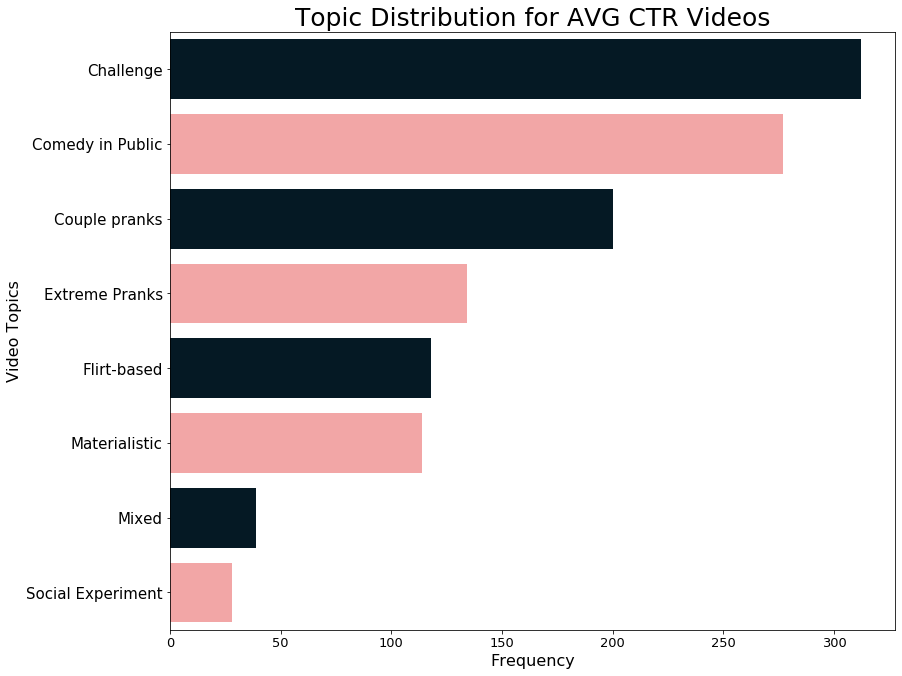

In [44]:
avg_x = avg_ctr['topics'].value_counts()
avg_y = avg_x.sort_index()
plt.figure(figsize=(13,11))
sns.barplot(avg_x, avg_y.index, palette=[c('tactiq'), c('background'),
                                             c('tactiq'), c('background'),
                                             c('tactiq'), c('background'),
                                             c('tactiq'), c('background')])
plt.title("Topic Distribution for AVG CTR Videos", fontsize=25)
plt.ylabel('Video Topics', fontsize=16)
plt.yticks(fontsize=15)
plt.xlabel('Frequency', fontsize=16)
plt.xticks(fontsize=13)

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 <a list of 8 Text xticklabel objects>)

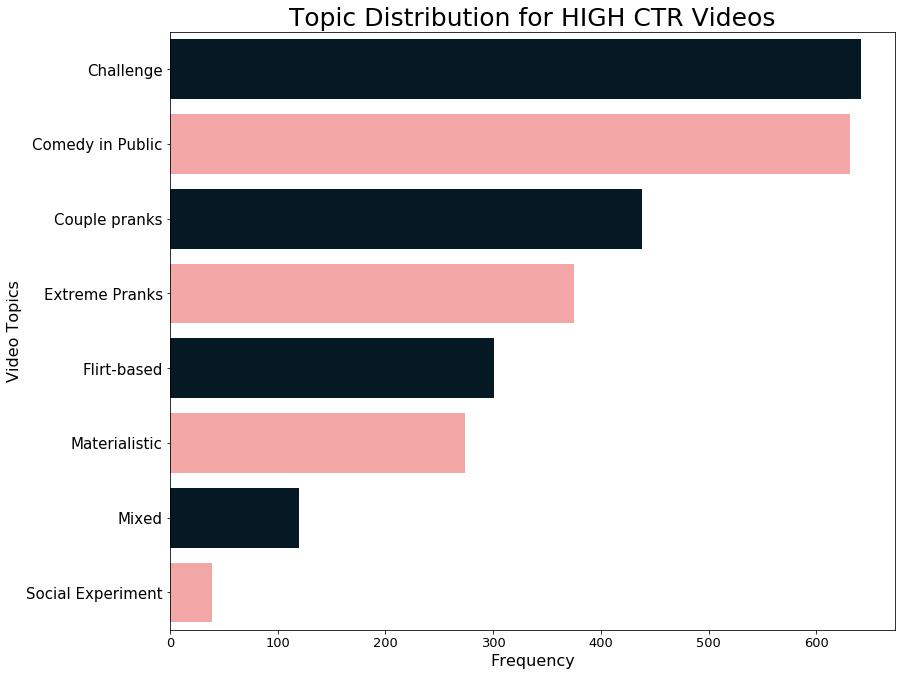

In [45]:
high_x = high_ctr['topics'].value_counts()
high_y = high_x.sort_index()
plt.figure(figsize=(13,11))
sns.barplot(high_x, high_y.index,  palette=[c('tactiq'), c('background'),
                                             c('tactiq'), c('background'),
                                             c('tactiq'), c('background'),
                                             c('tactiq'), c('background')])
plt.title("Topic Distribution for HIGH CTR Videos", fontsize=25)
plt.ylabel('Video Topics', fontsize=16)
plt.yticks(fontsize=15)
plt.xlabel('Frequency', fontsize=16)
plt.xticks(fontsize=13)

### Explore Bigrams 

In the context of a YouTube title, words are less valuable on their own, so I'm interested to see which two-word combinations dominate the dataset. Let's use bigrams to explore that:

In [46]:
#Create a new DataFrame where all words are grouped by CTR class
ctr_corpora = df[['ctr_range', 'lemma_str']]
ctr_corpora = ctr_corpora.groupby(by='ctr_range').agg(lambda x:' '.join(x))

#Preview
ctr_corpora

,lemma_str
ctr_range,
Avg CTR,naked guy picking girl naked guy picking girl ...
High CTR,hitting female cop flirting nice american fema...
Low CTR,edgard try sell brazilian girl back carnival b...


In [47]:
#Let's use Count Vectorizer to create a doc-term matrix, this time for bigrams
cv2 = CountVectorizer(analyzer='word', stop_words=stopwords, ngram_range=(2,2))
data = cv2.fit_transform(ctr_corpora.lemma_str)

df_bigr = pd.DataFrame(data.toarray(), columns=cv2.get_feature_names())
df_bigr.index = ctr_corpora.index
df_bigr

,ab daylight,ab easy,ab funny,ab nightclub,ab prank,ab social,ab workout,abandon zoo,abandoned building,abandoned car,...,zombie valentine,zone girl,zone outdated,zoned prank,zoo got,zoo hide,zoo picking,zoo welcoming,zooming people,zuckerberg teenager
ctr_range,,,,,,,,,,,,,,,,,,,,,
Avg CTR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
High CTR,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Low CTR,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,1,1


There are over 21,000 bigrams in our dataset, which is not bad. Next, let's look into the most common phrases:

In [48]:
all_words = data.sum(axis=0)
words_freq = [(word, all_words[0, idx]) for word, idx in cv2.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
words_freq[:25]

[('gold digger', 1356),
 ('digger prank', 842),
 ('kissing prank', 596),
 ('social experiment', 527),
 ('prank compilation', 395),
 ('public prank', 356),
 ('prank gone', 328),
 ('gone wrong', 277),
 ('try laugh', 266),
 ('must watch', 251),
 ('funny video', 196),
 ('prank part', 196),
 ('jurassic world', 196),
 ('world evolution', 194),
 ('funny prank', 188),
 ('prank extreme', 171),
 ('edition kissing', 165),
 ('laugh challenge', 146),
 ('prank invasion', 145),
 ('hot girl', 134),
 ('picking girl', 130),
 ('chair pulling', 126),
 ('prank best', 122),
 ('best laugh', 113),
 ('compilation ep', 108)]

In [49]:
#Let's convert that list of frequency tupules into a DataFrame for easier plotting:
bigram_freq_df = pd.DataFrame(words_freq, columns =['bigram', 'count'])
bigram_freq_top = bigram_freq_df.head(20)

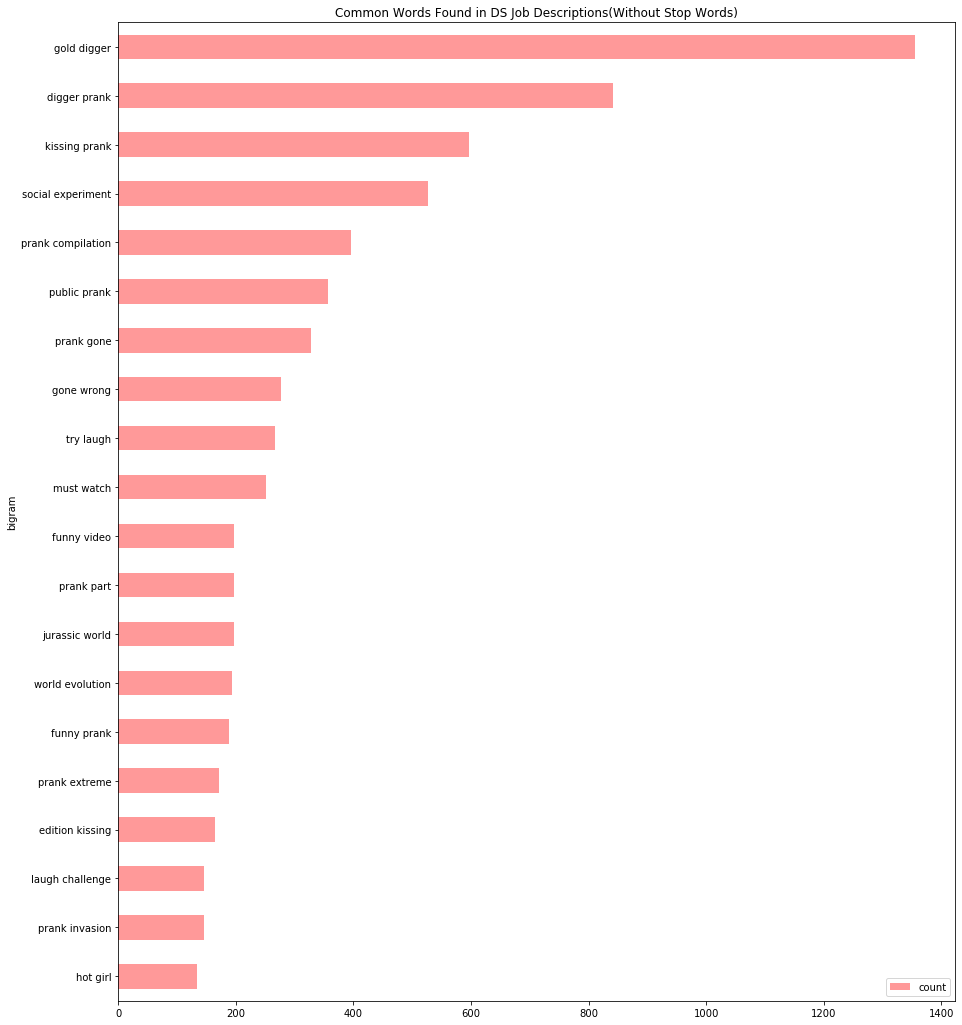

In [52]:
fig, ax = plt.subplots(figsize=(15,18))
bigram_freq_top.sort_values(by='count').plot.barh(x='bigram',
                      y='count',
                      ax=ax,
                      color=c('background'))

ax.set_title("Common Words Found in DS Job Descriptions(Without Stop Words)")

plt.show()

In [53]:
final_df = df[['clean_title','ctr_range','lemma_str']]

In [54]:
final_df.head(3)

,clean_title,ctr_range,lemma_str
0,hitting female cops,High CTR,hitting female cop
1,naked guy picking girls,Avg CTR,naked guy picking girl
2,flirting nice american female officer norwegian,High CTR,flirting nice american female officer norwegian


In [ ]:
#final_df.to_csv('final.csv',index=False)